### Importamos las librerias

In [392]:
import ast
import pandas as pd
import numpy as np
import seaborn as sns
from fastapi import FastAPI 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from fastapi import FastAPI, HTTPException
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from pydantic import BaseModel
from sklearn.decomposition import PCA
import pickle

### Accedemos al Dataset

In [393]:
games = []
with open('steam_games.json') as f: #permite acceder al contenido del archivo JSON
    for line in f.readlines():
        games.append(ast.literal_eval(line)) #convirtir cada línea del archivo JSON en un diccionario de Python y añadiéndolo a la lista games

df = pd.DataFrame(games) # carga los datos en un DataFrame de pandas

In [394]:
# Ver los primeros registros del DataFrame
df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [395]:
#Cambiar el dtype de la columna 'release_date' ya que contiene fechas en formato de texto
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [396]:
#Cambiar el dtype de la columna 'metascore' ya que contiene puntajes en formato de texto
df['metascore'] = pd.to_numeric(df['metascore'], errors='coerce')

In [397]:
#Revisar las columnas y tipos de datos despues de los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   publisher       24083 non-null  object        
 1   genres          28852 non-null  object        
 2   app_name        32133 non-null  object        
 3   title           30085 non-null  object        
 4   url             32135 non-null  object        
 5   release_date    29783 non-null  datetime64[ns]
 6   tags            31972 non-null  object        
 7   discount_price  225 non-null    float64       
 8   reviews_url     32133 non-null  object        
 9   specs           31465 non-null  object        
 10  price           30758 non-null  object        
 11  early_access    32135 non-null  bool          
 12  id              32133 non-null  object        
 13  developer       28836 non-null  object        
 14  sentiment       24953 non-null  object        
 15  me

### Realizamos el EDA

In [398]:
# Verificar la estructura del dataset
df.shape

(32135, 16)

In [399]:
# Mostrar los nombres de las columnas
df.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'early_access', 'id', 'developer', 'sentiment', 'metascore'],
      dtype='object')

In [400]:
# Verificar si hay valores faltantes en cada columna
df.isnull().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2352
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

In [401]:
# Verificar los valores únicos en la columna 'price'
print(df['price'].unique())

[4.99 'Free To Play' 'Free to Play' 0.99 2.99 3.99 9.99 18.99 29.99 nan
 'Free' 10.99 1.59 14.99 1.99 59.99 8.99 6.99 7.99 39.99 19.99 7.49 12.99
 5.99 2.49 15.99 1.25 24.99 17.99 61.99 3.49 11.99 13.99 'Free Demo'
 'Play for Free!' 34.99 74.76 1.49 32.99 99.99 14.95 69.99 16.99 79.99
 49.99 5.0 44.99 13.98 29.96 119.99 109.99 149.99 771.71 'Install Now'
 21.99 89.99 'Play WARMACHINE: Tactics Demo' 0.98 139.92 4.29 64.99
 'Free Mod' 54.99 74.99 'Install Theme' 0.89 'Third-party' 0.5 'Play Now'
 299.99 1.29 3.0 15.0 5.49 23.99 49.0 20.99 10.93 1.39
 'Free HITMAN™ Holiday Pack' 36.99 4.49 2.0 4.0 9.0 234.99 1.95 1.5 199.0
 189.0 6.66 27.99 10.49 129.99 179.0 26.99 399.99 31.99 399.0 20.0 40.0
 3.33 199.99 22.99 320.0 38.85 71.7 59.95 995.0 27.49 3.39 6.0 19.95
 499.99 16.06 4.68 131.4 44.98 202.76 1.0 2.3 0.95 172.24 249.99 2.97
 10.96 10.0 30.0 2.66 6.48 19.29 11.15 18.9 2.89 'Play the Demo' 99.0
 87.94 599.0 8.98 9.69 0.49 9.98 9.95 7.0 'Starting at $499.00'
 'Starting at $449.00' 12.8

In [402]:
# Reemplazar los valores de gratuidad con 0
df['price'] = df['price'].replace('Free.*', 0, regex=True)

In [403]:
# Reemplazar los valores que comienzan con 'Starting at $' por el valor numérico
df['price'] = df['price'].replace('Starting at \$', '', regex=True)

In [404]:
# Verificar los valores únicos en la columna 'price' después de las tranformaciones
print(df['price'].unique())

[4.99 0 0.99 2.99 3.99 9.99 18.99 29.99 nan 10.99 1.59 14.99 1.99 59.99
 8.99 6.99 7.99 39.99 19.99 7.49 12.99 5.99 2.49 15.99 1.25 24.99 17.99
 61.99 3.49 11.99 13.99 34.99 74.76 1.49 32.99 99.99 14.95 69.99 16.99
 79.99 49.99 5.0 44.99 13.98 29.96 119.99 109.99 149.99 771.71
 'Install Now' 21.99 89.99 'Play WARMACHINE: Tactics Demo' 0.98 139.92
 4.29 64.99 54.99 74.99 'Install Theme' 0.89 'Third-party' 0.5 'Play Now'
 299.99 1.29 3.0 15.0 5.49 23.99 49.0 20.99 10.93 1.39 36.99 4.49 2.0 4.0
 9.0 234.99 1.95 1.5 199.0 189.0 6.66 27.99 10.49 129.99 179.0 26.99
 399.99 31.99 399.0 20.0 40.0 3.33 199.99 22.99 320.0 38.85 71.7 59.95
 995.0 27.49 3.39 6.0 19.95 499.99 16.06 4.68 131.4 44.98 202.76 1.0 2.3
 0.95 172.24 249.99 2.97 10.96 10.0 30.0 2.66 6.48 19.29 11.15 18.9 2.89
 'Play the Demo' 99.0 87.94 599.0 8.98 9.69 0.49 9.98 9.95 7.0 '499.00'
 '449.00' 12.89 6.49 1.87 42.99 41.99 289.99 23.96 5.65 12.0 13.37 189.96
 124.99 19.98 160.91]


In [405]:
#Reemplazar los valores no numéricos por NaN
valores_no_num = ['Play the Demo', 'Install Theme', 'Install Now', 'Play WARMACHINE: Tactics Demo', 'Install Theme', 'Third-party', 'Play Now']
df['price'] = df['price'].replace(valores_no_num, float('nan'))

#Eliminar filas con valores NaN en la columna 'price'
df = df.dropna(subset=['price'])

In [406]:
#Verificar valores faltantes en la columna 'price'
df['price'].isnull().sum()

0

In [407]:
# Eliminamos los valores faltantes en las columnas 'price' y 'metascore'
df_limpio = df.dropna(subset=['price', 'metascore'])

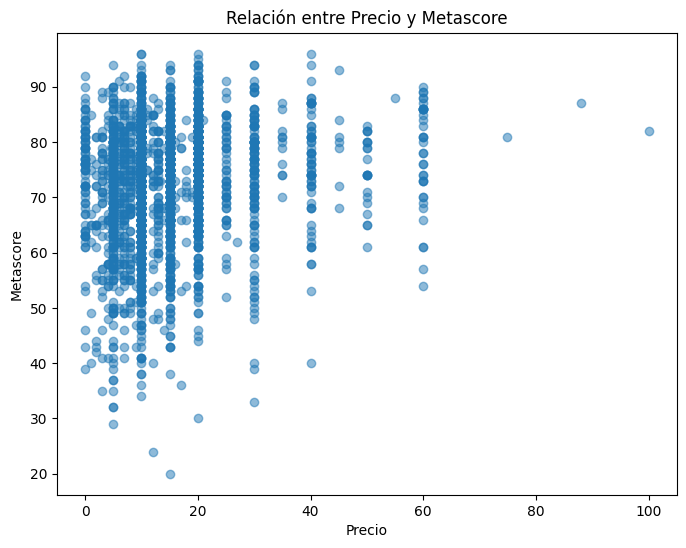

In [408]:
# Crear un gráfico de dispersión para visualizar la relación entre el precio y el metascore
plt.figure(figsize=(8, 6))
plt.scatter(df_limpio['price'], df_limpio['metascore'], alpha=0.5)
plt.xlabel('Precio')
plt.ylabel('Metascore')
plt.title('Relación entre Precio y Metascore')
plt.show()


In [409]:
# Extraer el año de la fecha y agregarlo como una nueva columna 'year'
df['year'] = df['release_date'].dt.year

# Eliminar las filas que tienen valores NaN en la columna 'year'
df = df.dropna(subset=['year'])

In [410]:
# Contar la cantidad de juegos lanzados en cada año
games_by_year = df['year'].value_counts().sort_index()

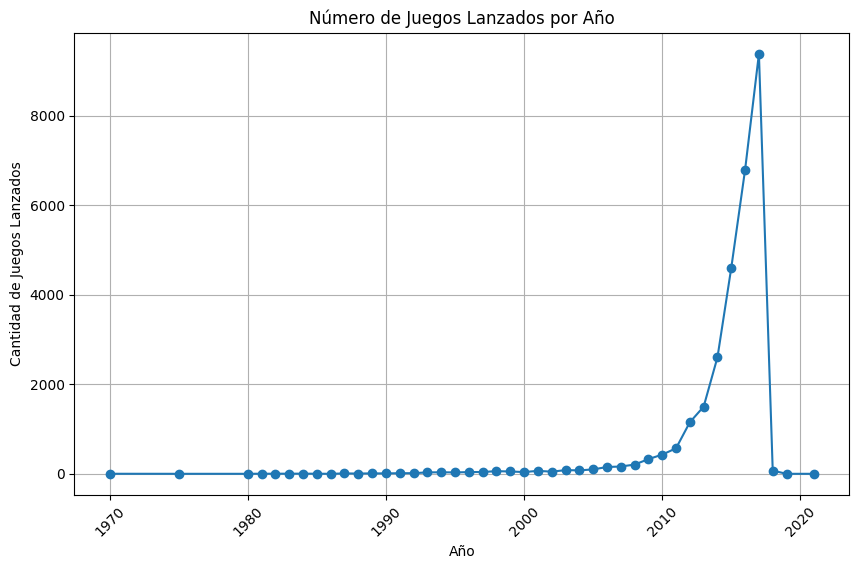

In [411]:
# Crear un gráfico de líneas para visualizar el número de juegos lanzados por año
plt.figure(figsize=(10, 6))
plt.plot(games_by_year.index, games_by_year.values, marker='o')
plt.xlabel('Año')
plt.ylabel('Cantidad de Juegos Lanzados')
plt.title('Número de Juegos Lanzados por Año')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

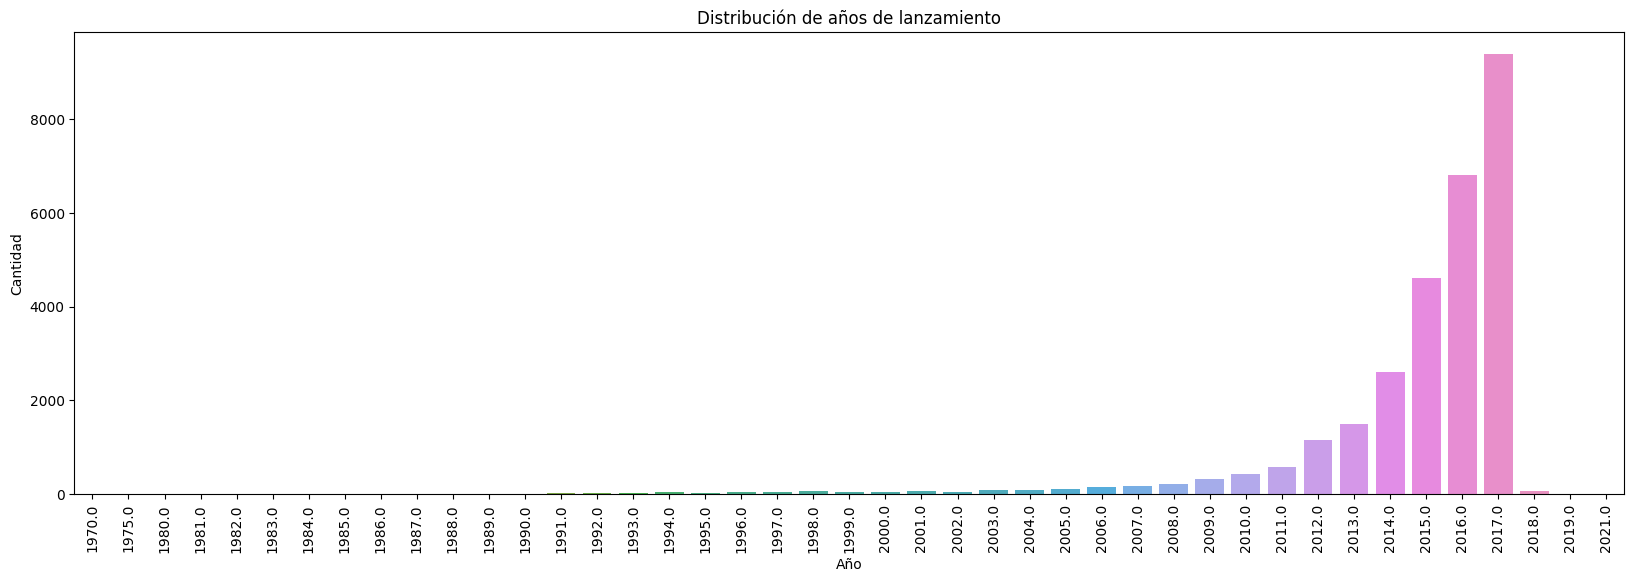

In [412]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='year')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Distribución de años de lanzamiento')
plt.xticks(rotation=90)
plt.show()

In [413]:
# Desanidar los datos de la columna 'genres'
df_exploded = df.explode('genres')

# Obtener los géneros únicos
unique_genres = df_exploded['genres'].unique()

# Imprimir los géneros únicos
print(unique_genres)

['Action' 'Casual' 'Indie' 'Simulation' 'Strategy' 'Free to Play' 'RPG'
 'Sports' 'Adventure' 'Racing' nan 'Early Access' 'Massively Multiplayer'
 'Animation &amp; Modeling' 'Web Publishing' 'Education'
 'Software Training' 'Utilities' 'Design &amp; Illustration'
 'Audio Production' 'Video Production' 'Photo Editing' 'Accounting']


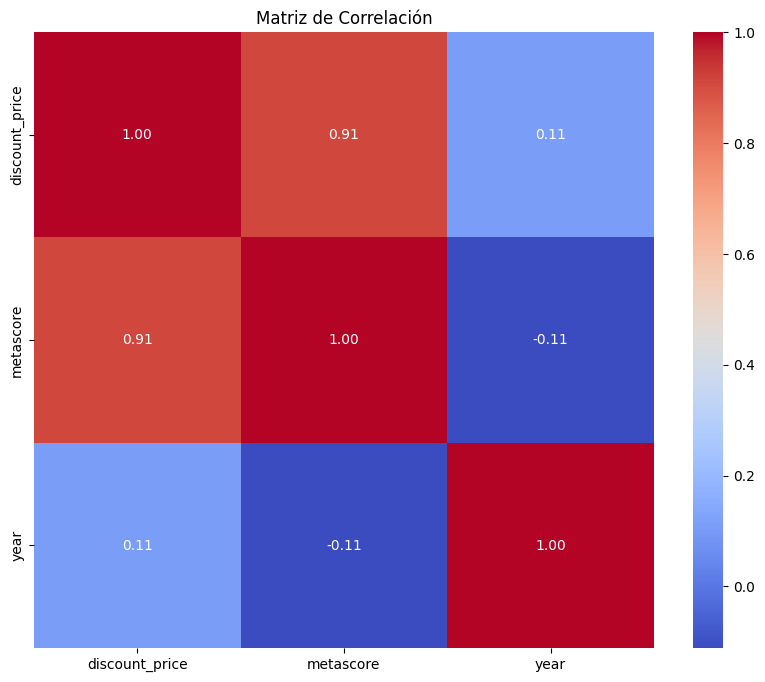

In [414]:
# Supongamos que 'df' es tu DataFrame y contiene algunas columnas no numéricas que queremos excluir
# Creamos una copia del DataFrame solo con las columnas numéricas para calcular la matriz de correlación
numeric_df = df.select_dtypes(include=[np.number])

# Calculamos la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear un mapa de calor usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # fmt=".2f" para mostrar 2 decimales en los valores de correlación
plt.title('Matriz de Correlación')
plt.show()

Para ver los outliers de las columnas 'price' y 'metascore'

In [415]:
print(df['price'].unique())

[4.99 0 0.99 3.99 9.99 18.99 29.99 10.99 2.99 1.59 14.99 1.99 59.99 8.99
 6.99 7.99 39.99 19.99 7.49 12.99 5.99 2.49 15.99 1.25 24.99 17.99 61.99
 3.49 11.99 13.99 34.99 1.49 32.99 99.99 14.95 69.99 16.99 79.99 49.99 5.0
 44.99 13.98 29.96 119.99 109.99 149.99 771.71 21.99 89.99 0.98 139.92
 4.29 64.99 54.99 74.99 0.89 0.5 299.99 1.29 3.0 15.0 5.49 23.99 49.0
 20.99 10.93 1.39 36.99 4.49 2.0 4.0 234.99 1.95 1.5 199.0 189.0 6.66
 27.99 10.49 129.99 179.0 26.99 399.99 31.99 399.0 20.0 40.0 3.33 22.99
 320.0 38.85 71.7 995.0 27.49 3.39 6.0 19.95 499.99 199.99 16.06 4.68
 131.4 44.98 202.76 1.0 2.3 0.95 172.24 249.99 2.97 10.96 10.0 30.0 2.66
 6.48 19.29 11.15 99.0 87.94 599.0 0.49 9.98 9.95 7.0 '499.00' '449.00'
 12.89 6.49 1.87 42.99 41.99 289.99 23.96 5.65 12.0 59.95 13.37 189.96
 124.99 19.98 160.91]


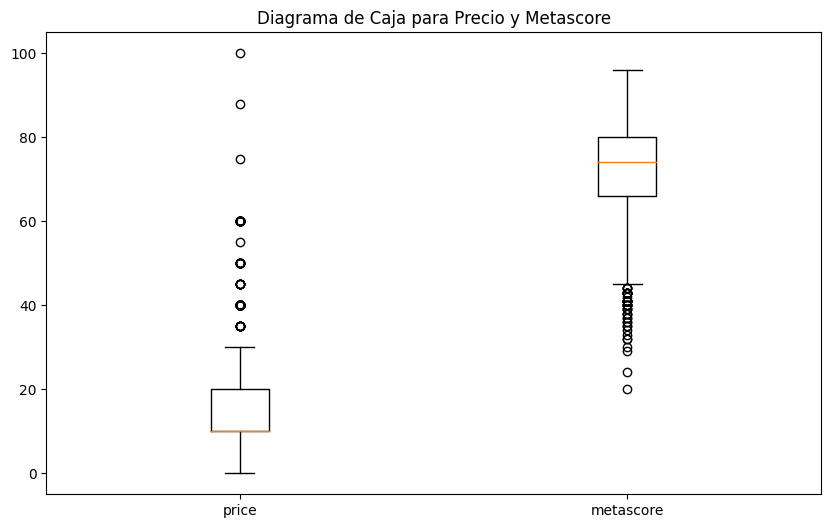

In [416]:
# Generar el diagrama de caja para 'price' y 'metascore'
plt.figure(figsize=(10, 6))
df_boxplot = df_limpio[['price', 'metascore']]
plt.boxplot(df_boxplot.values, labels=df_boxplot.columns)
plt.title('Diagrama de Caja para Precio y Metascore')
plt.show()

In [417]:
df_limpio['price'].describe()

count     2584.00
unique      45.00
top          9.99
freq       682.00
Name: price, dtype: float64

Crear nube de palabras

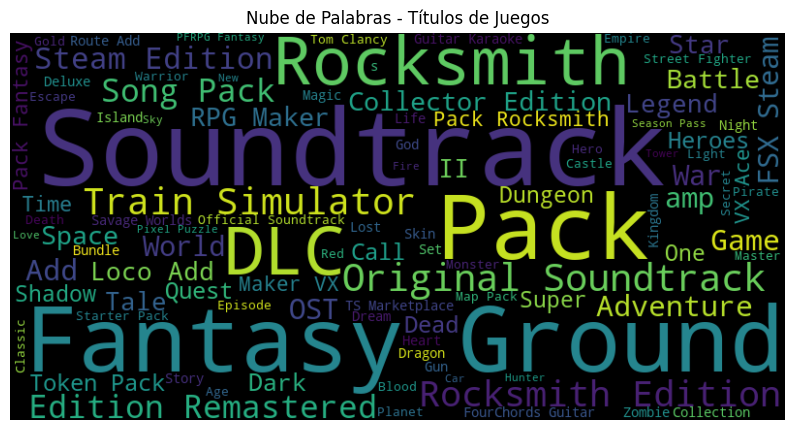

In [418]:
# Preparar los datos
titles = df['title'].dropna()  # Eliminar títulos faltantes
text = ' '.join(titles)  # Combinar los títulos en un solo texto

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Títulos de Juegos')
plt.show()


In [419]:
# Contar la cantidad de juegos en cada modalidad de Early Access
early_access_counts = df['early_access'].value_counts()

# Imprimir los resultados
print(early_access_counts)

early_access
False    27391
True      1383
Name: count, dtype: int64


### Modelado

In [421]:
df_limpio.dtypes

publisher                 object
genres                    object
app_name                  object
title                     object
url                       object
release_date      datetime64[ns]
tags                      object
discount_price           float64
reviews_url               object
specs                     object
price                     object
early_access                bool
id                        object
developer                 object
sentiment                 object
metascore                float64
dtype: object

In [422]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor

def prediccion(genres, metascore, early_access):
    # Filtrar los registros con valores no nulos en la columna 'genres'
    df_filtrado = df_limpio[df_limpio['genres'].notnull()]

    # Paso 1: Filtrar el DataFrame según el género y la disponibilidad anticipada
    df_filtrado = df_filtrado[(df_filtrado['genres'].apply(lambda x: genres in x)) & (df_filtrado['early_access'] == early_access)]

    # Paso 2: Preparar los datos (asegúrate de haber realizado las transformaciones previas)
    X = df_filtrado[['metascore', 'early_access']]
    X['year'] = df_filtrado['release_date'].dt.year  # Extraer el año de la columna 'release_date'

    # Crear columnas para cada género utilizando one-hot encoding con prefijo 'genre'
    genres_encoded = pd.get_dummies(df_filtrado['genres'].apply(pd.Series).stack(), prefix='genre').groupby(level=0).sum()
    # Combinar las características codificadas con la matriz X
    X = pd.concat([X, genres_encoded], axis=1)

    y = df_filtrado['price']

    # Eliminar filas con valores faltantes
    X.dropna(inplace=True)
    y = y[X.index]

    # Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paso 4: Crear el modelo base de regresión lineal
    base_model = LinearRegression()

    # Paso 5: Crear el modelo de Bagging utilizando el modelo base
    bagging_model = BaggingRegressor(base_model, n_estimators=10, random_state=42)

    # Paso 6: Entrenar el modelo de Bagging con los datos de entrenamiento
    bagging_model.fit(X_train, y_train)

    # Paso 7: Realizar predicciones con el modelo de Bagging
    y_test_pred = bagging_model.predict(X_test)

    # Paso 8: Calcular el RMSE
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    return y_test_pred, rmse

# Ejemplo de uso:
genero_elegido = 'Action'
metascore_elegido = 85.0
earlyaccess_elegido = True

predicciones, rmse_result = prediccion(genero_elegido, metascore_elegido, earlyaccess_elegido)
print("Predicciones de precios:", predicciones)
print("RMSE:", rmse_result)


Predicciones de precios: [7.99]
RMSE: 11.999999999999998


C:\Users\Angie Arango\AppData\Local\Temp\ipykernel_32552\3642570728.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['year'] = df_filtrado['release_date'].dt.year  # Extraer el año de la columna 'release_date'


In [440]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
import pickle

# Asegurarse de que 'release_date' sea de tipo datetime
df_limpio['release_date'] = pd.to_datetime(df_limpio['release_date'])

def train_bagging_model(genres, metascore, year):
    # Filtrar los registros con valores no nulos en la columna 'genres'
    df_filtrado = df_limpio[df_limpio['genres'].notnull()]

    # Paso 1: Filtrar el DataFrame según el género y la disponibilidad anticipada
    df_filtrado = df_filtrado[(df_filtrado['genres'].apply(lambda x: genres in x))]

    # Paso 2: Preparar los datos (asegúrate de haber realizado las transformaciones previas)
    df_filtrado['year'] = df_filtrado['release_date'].dt.year  # Crear una nueva columna 'year' con el año extraído de 'release_date'
    X = df_filtrado[['metascore', 'year']]  # Incluir las variables metascore, year y early_access
    # Crear columnas para cada género utilizando one-hot encoding con prefijo 'genre'
    genres_encoded = pd.get_dummies(df_filtrado['genres'].apply(pd.Series).stack(), prefix='genre').groupby(level=0).sum()
    # Combinar las características codificadas con la matriz X
    X = pd.concat([X, genres_encoded], axis=1)

    y = df_filtrado['price']

    # Eliminar filas con valores faltantes
    X.dropna(inplace=True)
    y = y[X.index]

    # Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paso 4: Crear el modelo base de regresión lineal
    base_model = LinearRegression()

    # Paso 5: Crear el modelo de Bagging utilizando el modelo base
    bagging_model = BaggingRegressor(base_model, n_estimators=10, random_state=42)

    # Paso 6: Entrenar el modelo de Bagging con los datos de entrenamiento
    bagging_model.fit(X_train, y_train)

    # Paso 7: Realizar predicciones con el modelo de Bagging
    y_test_pred = bagging_model.predict(X_test)

    # Paso 8: Calcular el RMSE
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    # Guardar el modelo entrenado utilizando pickle
    with open('bagging_model.pkl', 'wb') as model_file:
        pickle.dump(bagging_model, model_file)

    return rmse

# Ejemplo de uso:
genero_elegido = 'Action'
metascore_elegido = 85.0
year_elegido = 2017

rmse_result = train_bagging_model(genero_elegido, metascore_elegido, year_elegido)
print("RMSE del modelo de Bagging:", rmse_result)


RMSE del modelo de Bagging: 6.998525330770722


In [447]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor

# Asegurarse de que 'release_date' sea de tipo datetime
df_limpio['release_date'] = pd.to_datetime(df_limpio['release_date'])

def train_bagging_model(genres, metascore, year):
    # Filtrar los registros con valores no nulos en la columna 'genres'
    df_filtrado = df_limpio[df_limpio['genres'].notnull()]

    # Paso 1: Filtrar el DataFrame según el género y la disponibilidad anticipada
    df_filtrado = df_filtrado[(df_filtrado['genres'].apply(lambda x: genres in x if isinstance(x, list) else False))]

    # Paso 2: Preparar los datos (asegúrate de haber realizado las transformaciones previas)
    df_filtrado['year'] = df_filtrado['release_date'].dt.year  # Crear una nueva columna 'year' con el año extraído de 'release_date'
    X = df_filtrado[['metascore', 'year']]  # Incluir las variables metascore, year y early_access

    # Obtener todos los géneros únicos presentes en el DataFrame
    all_genres = set()
    for genre_list in df_filtrado['genres']:
        if isinstance(genre_list, list):
            all_genres.update(genre_list)
    all_genres = sorted(list(all_genres))

    # Crear columnas para cada género utilizando one-hot encoding con prefijo 'genre'
    genres_encoded = pd.get_dummies(df_filtrado['genres'].apply(pd.Series).stack(), prefix='genre').groupby(level=0).sum()

    # Combinar las características codificadas con la matriz X
    X = pd.concat([X, genres_encoded], axis=1)

    y = df_filtrado['price']

    # Eliminar filas con valores faltantes
    X.dropna(inplace=True)
    y = y[X.index]

    # Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paso 4: Crear el modelo base de regresión lineal
    base_model = LinearRegression()

    # Paso 5: Crear el modelo de Bagging utilizando el modelo base
    bagging_model = BaggingRegressor(base_model, n_estimators=10, random_state=42)

    # Paso 6: Entrenar el modelo de Bagging con los datos de entrenamiento
    bagging_model.fit(X_train, y_train)

    # Paso 7: Realizar predicciones con el modelo de Bagging
    y_test_pred = bagging_model.predict(X_test)

    # Paso 8: Calcular el RMSE
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    # Guardar el modelo entrenado utilizando pickle
    with open('bagging_model.pkl', 'wb') as model_file:
        pickle.dump(bagging_model, model_file)

    return rmse

# Ejemplo de uso:
genero_elegido = 'Action'
metascore_elegido = 85.0
year_elegido = 2017

rmse_result = train_bagging_model(genero_elegido, metascore_elegido, year_elegido)
print("RMSE del modelo de Bagging:", rmse_result)


RMSE del modelo de Bagging: 6.998525330770722


In [448]:
import pickle
from fastapi import FastAPI

app = FastAPI()

# Cargar el modelo entrenado con pickle
with open('bagging_model.pkl', 'rb') as model_file:
    bagging_model = pickle.load(model_file)

@app.get("/")
async def read_root():
    return {"message": "¡Bienvenido a la API de predicciones de precios de juegos!"}

@app.get("/predict/")
async def predict_price(genres: str, metascore: float, year: int):
    # Crear la matriz de características para hacer la predicción
    X = [[metascore, year]]
    # Agregar columnas para los géneros, todas con valor 0 (no seleccionados)
    genres_list = genres.split(",")
    for genre in genres_list:
        X[0].append(0)
    # Codificar los géneros seleccionados con valor 1
    for genre in genres_list:
        genre_index = 2 + genres_list.index(genre)
        X[0][genre_index] = 1

    # Realizar la predicción utilizando el modelo de Bagging
    predicted_price = bagging_model.predict(X)[0]

    # Calcular el RMSE para mostrarlo en la respuesta
    rmse_result = 0.0  # Asegurémonos de que sea un valor numérico
    try:
        # Cargar el RMSE del archivo de texto (si existe)
        with open('bagging_rmse.txt', 'r') as rmse_file:
            rmse_result = float(rmse_file.read())
    except FileNotFoundError:
        pass

    return {"predicted_price": predicted_price, "rmse": rmse_result}
